In [151]:
################################################################################
# CS 224W (Fall 2017) - HW1
# Code for Problem 1
# Author: luis0@stanford.edu
# Last Updated: Oct 8, 2017
################################################################################

import snap
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum

# 2.1: Node Positions

In [39]:
# Load networks.
def loadNetworks():
    '''
    Loads the epinions and email networks.
    returns: (epinions, email)
    '''
    epinions = snap.LoadEdgeList(
        snap.PNGraph, "data/soc-Epinions1.txt", 0, 1, "\t")
    assert epinions.GetNodes() == 75879
    assert epinions.GetEdges() == 508837
    email = snap.LoadEdgeList(
        snap.PNGraph, "data/email-EuAll.txt", 0, 1, "\t")
    assert email.GetNodes() == 265214
    assert email.GetEdges() == 420045
    return (epinions, email)

In [53]:
class Location(Enum):
    IN = "In Component"
    OUT = "Out Component"
    SCC = "Strongly Connected Component"
    AMBIGUOUS = "Ambiguous Component"
    
def determineLocation(Graph, nodeID):
    '''
    Given a nodeID, determines if it belongs to the SCC, IN, or OUT
    components of the Graph using heuristics and assuming the Graph
    has a BowTie structure.
    
    Assumptions based on Experiments:
        IN nodes have < 1e-4% backwards trees, > 15% forward.
        OUT nodes have < 1e-4% forward trees, > 15% forward.
        SCC nodes have > 15% in both directions.
        All else is considered "AMBIGUOUS"
        
    returns: Location
    '''
    forwardTree = snap.GetBfsTree(Graph, nodeID, True, False)
    backwardTree = snap.GetBfsTree(Graph, nodeID, False, True)
    N = float(Graph.GetNodes())
    forward_p = forwardTree.GetNodes() / N
    backward_p = backwardTree.GetNodes() / N
    if forward_p > 0.15 and backward_p < 1e-4: return Location.IN
    if forward_p < 1e-4 and backward_p > 0.15: return Location.OUT
    if forward_p > 0.15 and backward_p > 0.15: return Location.SCC
    return Location.AMBIGUOUS

In [56]:
def Q2_1():
    epinions, email = loadNetworks()
    
    idToNetwork = {9809: ("epinions", epinions),
                   1952: ("epinions", epinions),
                   189587: ("email", email),
                   675: ("email", email)}
    for (nodeID, (name, Graph)) in idToNetwork.iteritems():
        print("Node %s in the %s graph belongs to the %s." % (
                nodeID, name, determineLocation(Graph, nodeID).value))

In [57]:
# Run Question 2.1 rough approximations.
Q2_1()

Node 1952 in the epinions graph belongs to the In Component.
Node 9809 in the epinions graph belongs to the Out Component.
Node 189587 in the email graph belongs to the Strongly Connected Component.
Node 675 in the email graph belongs to the Out Component.


## 2.1: Experiments.

In [103]:
def GetForwardBackwardProp(Graph, nodeID):
    '''
    Returns the proportion of nodes visited during a forward/backward
    bfs starting at nodeID
    '''
    
    forwardTree = snap.GetBfsTree(Graph, nodeID, True, False)
    backwardTree = snap.GetBfsTree(Graph, nodeID, False, True)
    return (float(forwardTree.GetNodes()) / Graph.GetNodes(),
            float(backwardTree.GetNodes()) / Graph.GetNodes())

In [104]:
# Load graphs.
epinions, email = loadNetworks()

### Email Model

In [119]:
# Let's find the size of the largest SCC.
emailSCC = snap.GetMxScc(email)
print("Email SCC: %s." % (
    100*float(emailSCC.GetNodes()) / email.GetNodes()))

Email SCC: 12.8963780193.


In [120]:
# The proposal is that 189587 is in SCC, so we have:
# SCC + OUT = 19.6456446492%
# OUT = 6.7492666299%
# SCC + IN =  69.8402045141%
# IN = 56.9438264948%
# OTHER: 23.410528856%
fp, bp =  GetForwardBackwardProp(email, 189587)
print("Forward %s and Backward %s for ID: %s." % (fp, bp, 189587))

Forward 0.196456446492 and Backward 0.698402045141 for ID: 189587.


In [121]:
# The proposal is that 675 is in OUT, so we have:
# SCC + IN + \epsilon =  69.8454832701%
fp, bp =  GetForwardBackwardProp(email, 675)
print("Forward %s and Backward %s for ID: %s." % (fp, bp, 675))

Forward 3.77054001674e-06 and Backward 0.698454832701 for ID: 675.


In [122]:
# We try one more random node to get a better picture.
# The proposal is that 0 is in IN, so we have:
# SCC + OUT + \epsilon =  19.6460217032%
fp, bp =  GetForwardBackwardProp(email, 0)
print("Forward %s and Backward %s for ID: %s." % (fp, bp, 0))

Forward 0.196460217032 and Backward 3.77054001674e-06 for ID: 0.


### Epinions Model

In [124]:
# Let's find the size of the largest SCC.
epinionsSCC = snap.GetMxScc(epinions)
print("Epinions SCC: %s." % (
    100*float(epinionsSCC.GetNodes()) / epinions.GetNodes()))

Epinions SCC: 42.4662950223.


In [109]:
# Proposal: 1952 is in IN region.
# SCC + OUT + \epsilon = 62.8329313776%
fp, bp =  GetForwardBackwardProp(epinions, 1952)
print("Forward %s and Backward %s for ID: %s." % (fp, bp, 1952))

Forward 0.628329313776 and Backward 1.31788768961e-05 for ID: 1952.


In [108]:
# Proposal: 9809 is in OUT region.
# SCC + IN + \epsilon = 74.4079389554%
fp, bp =  GetForwardBackwardProp(epinions, 9809)
print("Forward %s and Backward %s for ID: %s." % (fp, bp, 9809))

Forward 1.31788768961e-05 and Backward 0.744079389554 for ID: 9809.


In [128]:
# Proposal: 193 is in SCC region.
# SCC + OUT = 62.8316134899%
# OUT = 20.365318467599997%
# SCC + IN = 74.4066210678%
# IN = 31.940326045500006%
# REST = 5.2280604645999915%
fp, bp =  GetForwardBackwardProp(epinions, 193)
print("Forward %s and Backward %s for ID: %s." % (fp, bp, 193))

Forward 0.628316134899 and Backward 0.744066210678 for ID: 193.


# 2.2: Random-start BFS

In [129]:
NUM_NODES = 100
Rnd = snap.TRnd(42)
Rnd.Randomize()

In [131]:
def randomStartTraversalDistribution(Graph):
    '''
    returns: X, Y where X[i], Y[i] are the number of reached nodes during
    the forward and backward passes respectively for the i-th randomly
    chosen node.
    '''
    X, Y = [], []
    for i in xrange(NUM_NODES):
        srcID = Graph.GetRndNId(Rnd)
        X.append(snap.GetBfsTree(Graph, srcID, True, False).GetNodes())
        Y.append(snap.GetBfsTree(Graph, srcID, False, True).GetNodes())
    return X,Y

In [192]:
def getXYAxesFromBFSDistribution(dist):
    '''
    dist is an array of # of nodes visited on multiple bfs nodes and
    contains no 0 nodes.
    return: X,Y where (X[i],Y[i]) is the point to be plotted for the cdf
    of this this distribution.
    '''
    filtered = filter(lambda x: x > 0, dist)
    return ([float(i) / len(filtered) for i in xrange(len(filtered))],
            sorted(filtered))

In [193]:
def Q2_2():
    epinions, email = loadNetworks()
    for name, graph in [("email", email), ("epinions", epinions)]:
        forward, backward = randomStartTraversalDistribution(graph)
        for direction, dist in [("forward", forward),
                                ("backward", backward)]:
            X, Y = getXYAxesFromBFSDistribution(dist)
            plt.close()
            plt.plot(X, Y)
            plt.yscale("log", base=10)
            plt.xlabel("frac. of starting nodes")
            plt.ylabel("number of nodes reached")
            plt.title("Reachability using %s-links" % (
                      "out" if direction == "forward" else "in"))
            plt.savefig("output/bfs_cdf_%s_%s_graph" % (direction, name),
                        dpi=600)
            plt.show()

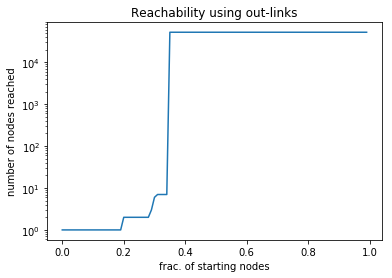

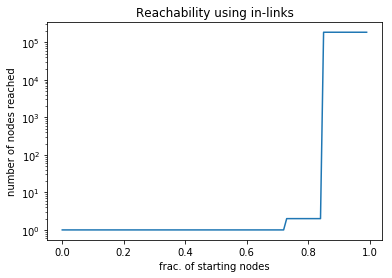

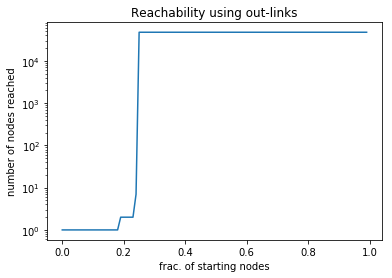

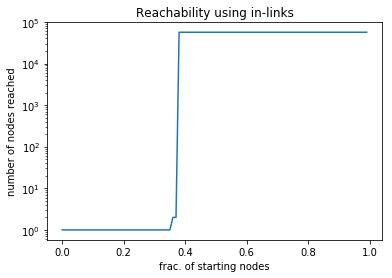

In [194]:
Q2_2()

### 2.2 Experiments

In [223]:
from collections import Counter

In [224]:
# Count of unique results for random start bfs for email.
Counter(zip(*randomStartTraversalDistribution(email)))

Counter({(1, 2): 6,
         (1, 3): 1,
         (1, 185227): 7,
         (2, 1): 15,
         (8, 1): 1,
         (52103, 185226): 19,
         (52104, 1): 51})

The BFS traversal behavior appears to imply that we have a bowtie structure since a very large percentage of the randomly chosen nodes "exploded" when following forward links (51%), 19% "exploded" when following both forward and back links, and a small minority (7%) when following backward links. The above also implies that we have a very large IN region (half of nodes), a relatively large SCC (1/5 of nodes), a small OUT region, with a somewhat large number of nodes completely disconnected from the graph (~23%) or forming very small tendrils.

In [225]:
# Count of unique results for random start bfs for epinions.
Counter(zip(*randomStartTraversalDistribution(epinions)))

Counter({(1, 2): 2,
         (1, 3): 1,
         (1, 56460): 17,
         (1, 56461): 1,
         (1, 56463): 1,
         (2, 1): 1,
         (2, 56461): 1,
         (3, 4): 1,
         (47676, 56459): 39,
         (47677, 1): 26,
         (47677, 2): 2,
         (47677, 3): 1,
         (47678, 1): 3,
         (47678, 2): 1,
         (47678, 3): 1,
         (47679, 1): 1,
         (47685, 12): 1})

The BFS traversal here also appears to imply a bowtie structure, though somewhat more complicated IN/OUT regions since it appears that it can take up to 10 steps to go from IN -> SCC and up to 3 to go from OUT -> SCC, so these regions appear more elongated. We still have, however, a large (39%) SCC, a large (20%) OUT region, a large (36%) IN region, and a small percentage of short tendrils or possibly disconnected regions (5%).

In [206]:
def SizeOfBowtieRegions(Graph, sccNodeID):
    '''
    Given a Graph with a BowTie structure as described in
    http://snap.stanford.edu/class/cs224w-readings/broder00bowtie.pdf
    and an sccNodeID of a node known to belong to the central SCC,
    determines the size of each component.
    
    returns: tuple of sizes (SCC, IN, OUT, TENDRILS, DISCONNECTED)
    '''
    totalNodes = Graph.GetNodes()
    wcc = snap.GetMxWcc(Graph)
    assert wcc.IsNode(sccNodeID)
    wccNodes = wcc.GetNodes()
    disconnectedNodes = totalNodes - wccNodes
    
    scc = snap.GetMxScc(Graph)
    # Sanity check the input.
    assert scc.IsNode(sccNodeID)
    sccNodes = scc.GetNodes()
    
    sccAndOutNodes = snap.GetBfsTree(
        Graph, sccNodeID, True, False).GetNodes()
    sccAndInNodes = snap.GetBfsTree(
        Graph, sccNodeID, False, True).GetNodes()
    
    inNodes = sccAndInNodes - sccNodes
    outNodes = sccAndOutNodes - sccNodes
    tendrilNodes = wccNodes - (inNodes + outNodes + sccNodes)
    
    nodes = (sccNodes, inNodes, outNodes, tendrilNodes, disconnectedNodes)
    assert sum(nodes) == Graph.GetNodes()
    return nodes

In [218]:
def Q2_3():
    '''
    The SCC knows are based on previous BFS experiments.
    '''
    epinions, email = loadNetworks()
    emailKnownSCCNode = 189587
    print("Size of regions in email network: "
          "SCC: %s, IN: %s, OUT: %s, TENDRILS: %s, "
          "DISCONNECTED: %s" % SizeOfBowtieRegions(email,
                                                 emailKnownSCCNode))
    epinionsKnownSCCNode = 193
    print("Size of regions in epinions network: "
          "SCC: %s, IN: %s, OUT: %s, TENDRILS: %s, "
          "DISCONNECTED: %s" % SizeOfBowtieRegions(epinions,
                                                  epinionsKnownSCCNode))

In [219]:
Q2_3()

Size of regions in email network: SCC: 34203, IN: 151023, OUT: 17900, TENDRILS: 21706, DISCONNECTED: 40382
Size of regions in epinions network: SCC: 32223, IN: 24236, OUT: 15453, TENDRILS: 3965, DISCONNECTED: 2


# 2.4: Probability of a Path Existing Between Two Randomly Chosen Nodes

## Uniformly Randomly Chosen

In [231]:
Rnd = snap.TRnd(42)
Rnd.Randomize()

In [247]:
NO_PATH = -1
def ProbabilityOfPath(Graph, nSamples=1000):
    '''
    Given a graph, returns the sampled probability of two nodes being
    connected. Takes nSamples of (u,v) pairs to check for path
    connectedness.
    '''
    paths = 0.0
    for _ in xrange(nSamples):
        u, v = Graph.GetRndNId(Rnd), Graph.GetRndNId(Rnd)
        if snap.GetShortPath(Graph, u, v, True) != NO_PATH: paths += 1
    return 100 * paths / nSamples

In [248]:
TRIALS = 3
def Q2_4():
    epinions, email = loadNetworks()
    for trial in xrange(TRIALS):
        for (name, network) in [("Epinions", epinions), ("Email", email)]:
            print("Probability of path for entire %s is %s." % (
                name, ProbabilityOfPath(network)))
            print("Probability of path in largest WCC of %s is %s." % (
                name, ProbabilityOfPath(snap.GetMxWcc(network))))

In [249]:
Q2_4()

Probability of path for entire Epinions is 45.8.
Probability of path in largest WCC of Epinions is 46.1.
Probability of path for entire Email is 13.0.
Probability of path in largest WCC of Email is 19.8.
Probability of path for entire Epinions is 48.6.
Probability of path in largest WCC of Epinions is 48.4.
Probability of path for entire Email is 14.0.
Probability of path in largest WCC of Email is 19.7.
Probability of path for entire Epinions is 45.7.
Probability of path in largest WCC of Epinions is 44.5.
Probability of path for entire Email is 13.0.
Probability of path in largest WCC of Email is 19.9.
